<a href="https://colab.research.google.com/github/till-tietz/voting_data_ocr/blob/ocr_testing/1990_election_ocr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For some reason the R interface for tesseract was being uncooperative so I had to implement the ocr script in python. 

#Dependency Setup 

The first four code blocks deal with dependency installation in the virtual environment.

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install imageio
!pip install re
!pip install opencv2
!pip install path
!pip install cv

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,497 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
import matplotlib.pyplot as plt
import pytesseract 
import imageio
import re
import cv
import cv2
import numpy as np
from pathlib import Path
from pytesseract import Output
from tensorflow.keras.preprocessing import image

ERROR:root:Error disabling cv.imshow().
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/google/colab/_import_hooks/_cv2.py", line 86, in load_module
    cv_module.imshow,
AttributeError: module 'cv' has no attribute 'imshow'


In order to make tesseract available in this environment you'll have to copy the output of **!which tesseract** into the section in quotations of the next code block 

In [ ]:
!which tesseract

/usr/bin/tesseract


In [ ]:
pytesseract.pytesseract.tesseract_cmd = (
    r'/usr/bin/tesseract'
)

#OCR Test 

This is a test/proof of concept for the OCR method. 
General idea: 
Tesseract creates bounding boxes around the text elements it identifies. Ideally we can thus do the following: 
1. find the column header for the left party (PDS-LL)
2. extract and buffer its bounding box 
3. return all text elements with x bound > min(header x bound) & x bound < max(header x bound) 

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
#load an image 
from google.colab import files
uploaded = files.upload()

Saving SB_B07-02-04_1990j05_BB_21.png to SB_B07-02-04_1990j05_BB_21.png


In [ ]:
#ocr image 
img = image.load_img("SB_B07-02-04_1990j05_BB_21.png")
img = image.img_to_array(img, dtype= 'uint8')


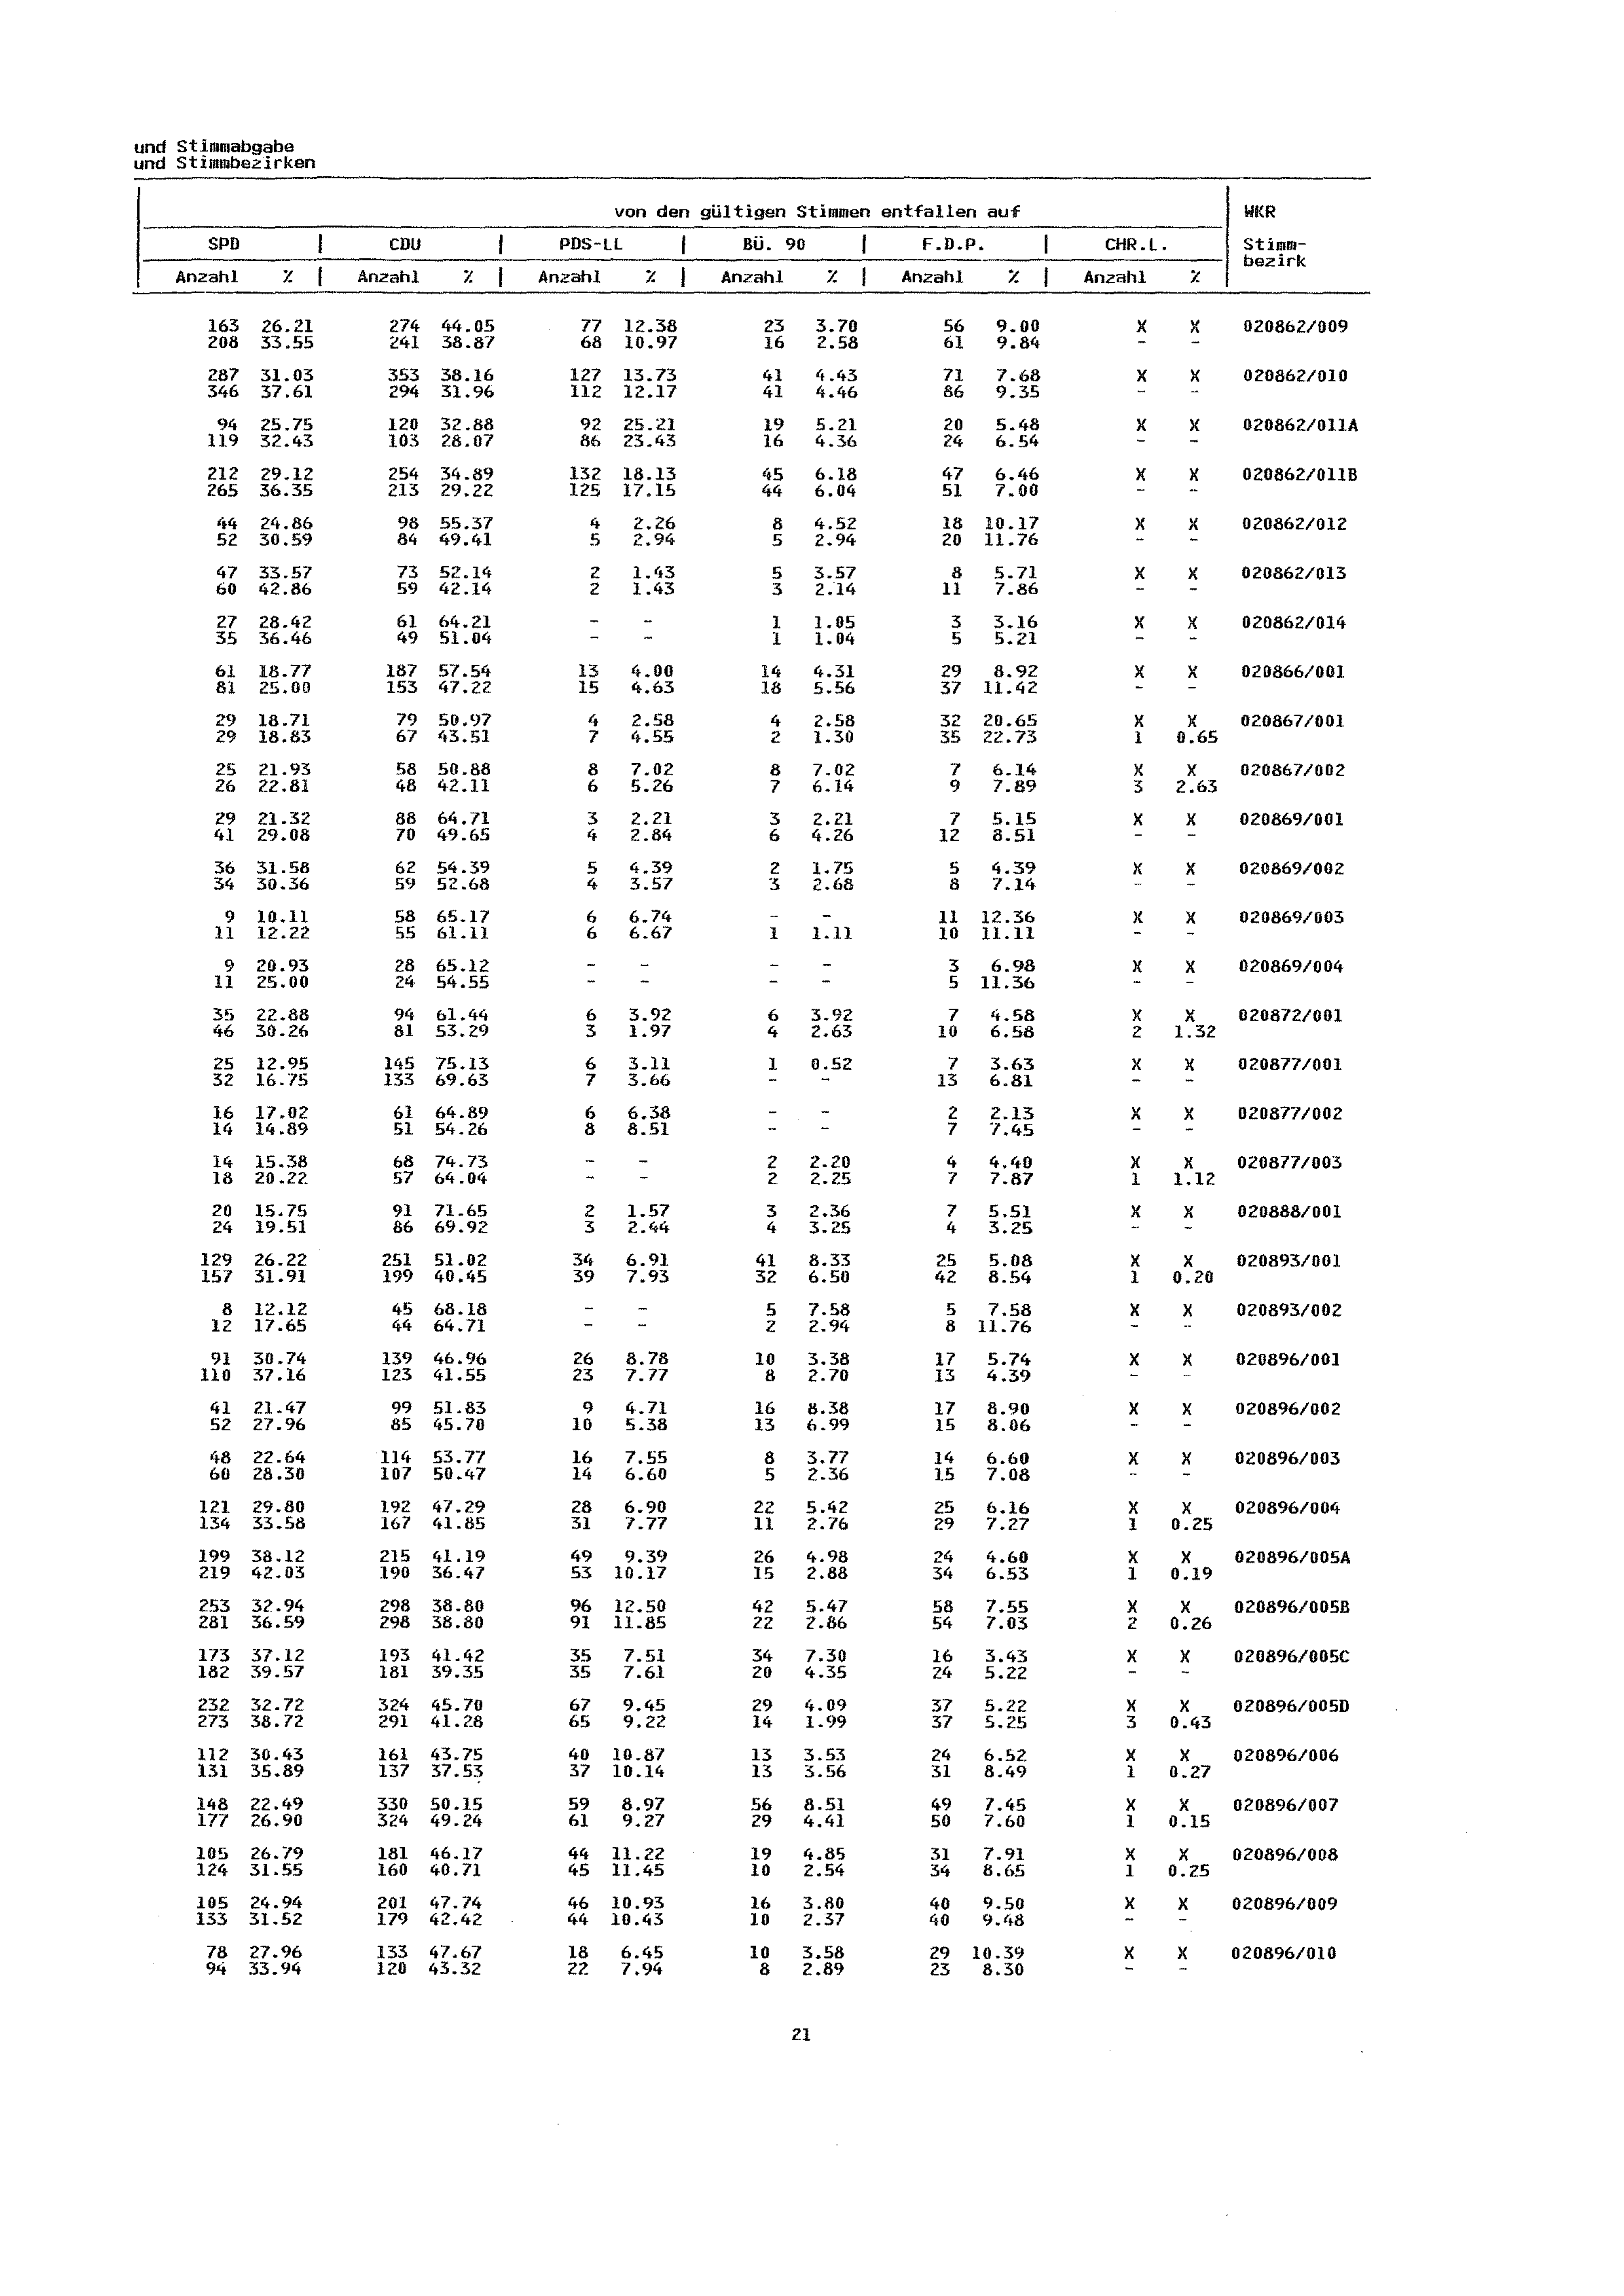

In [ ]:
cv2_imshow(img)

In [ ]:
d = pytesseract.image_to_data(img, output_type=Output.DICT) 
keys = list(d.keys())

Let's have a look at what we're identifying here. 

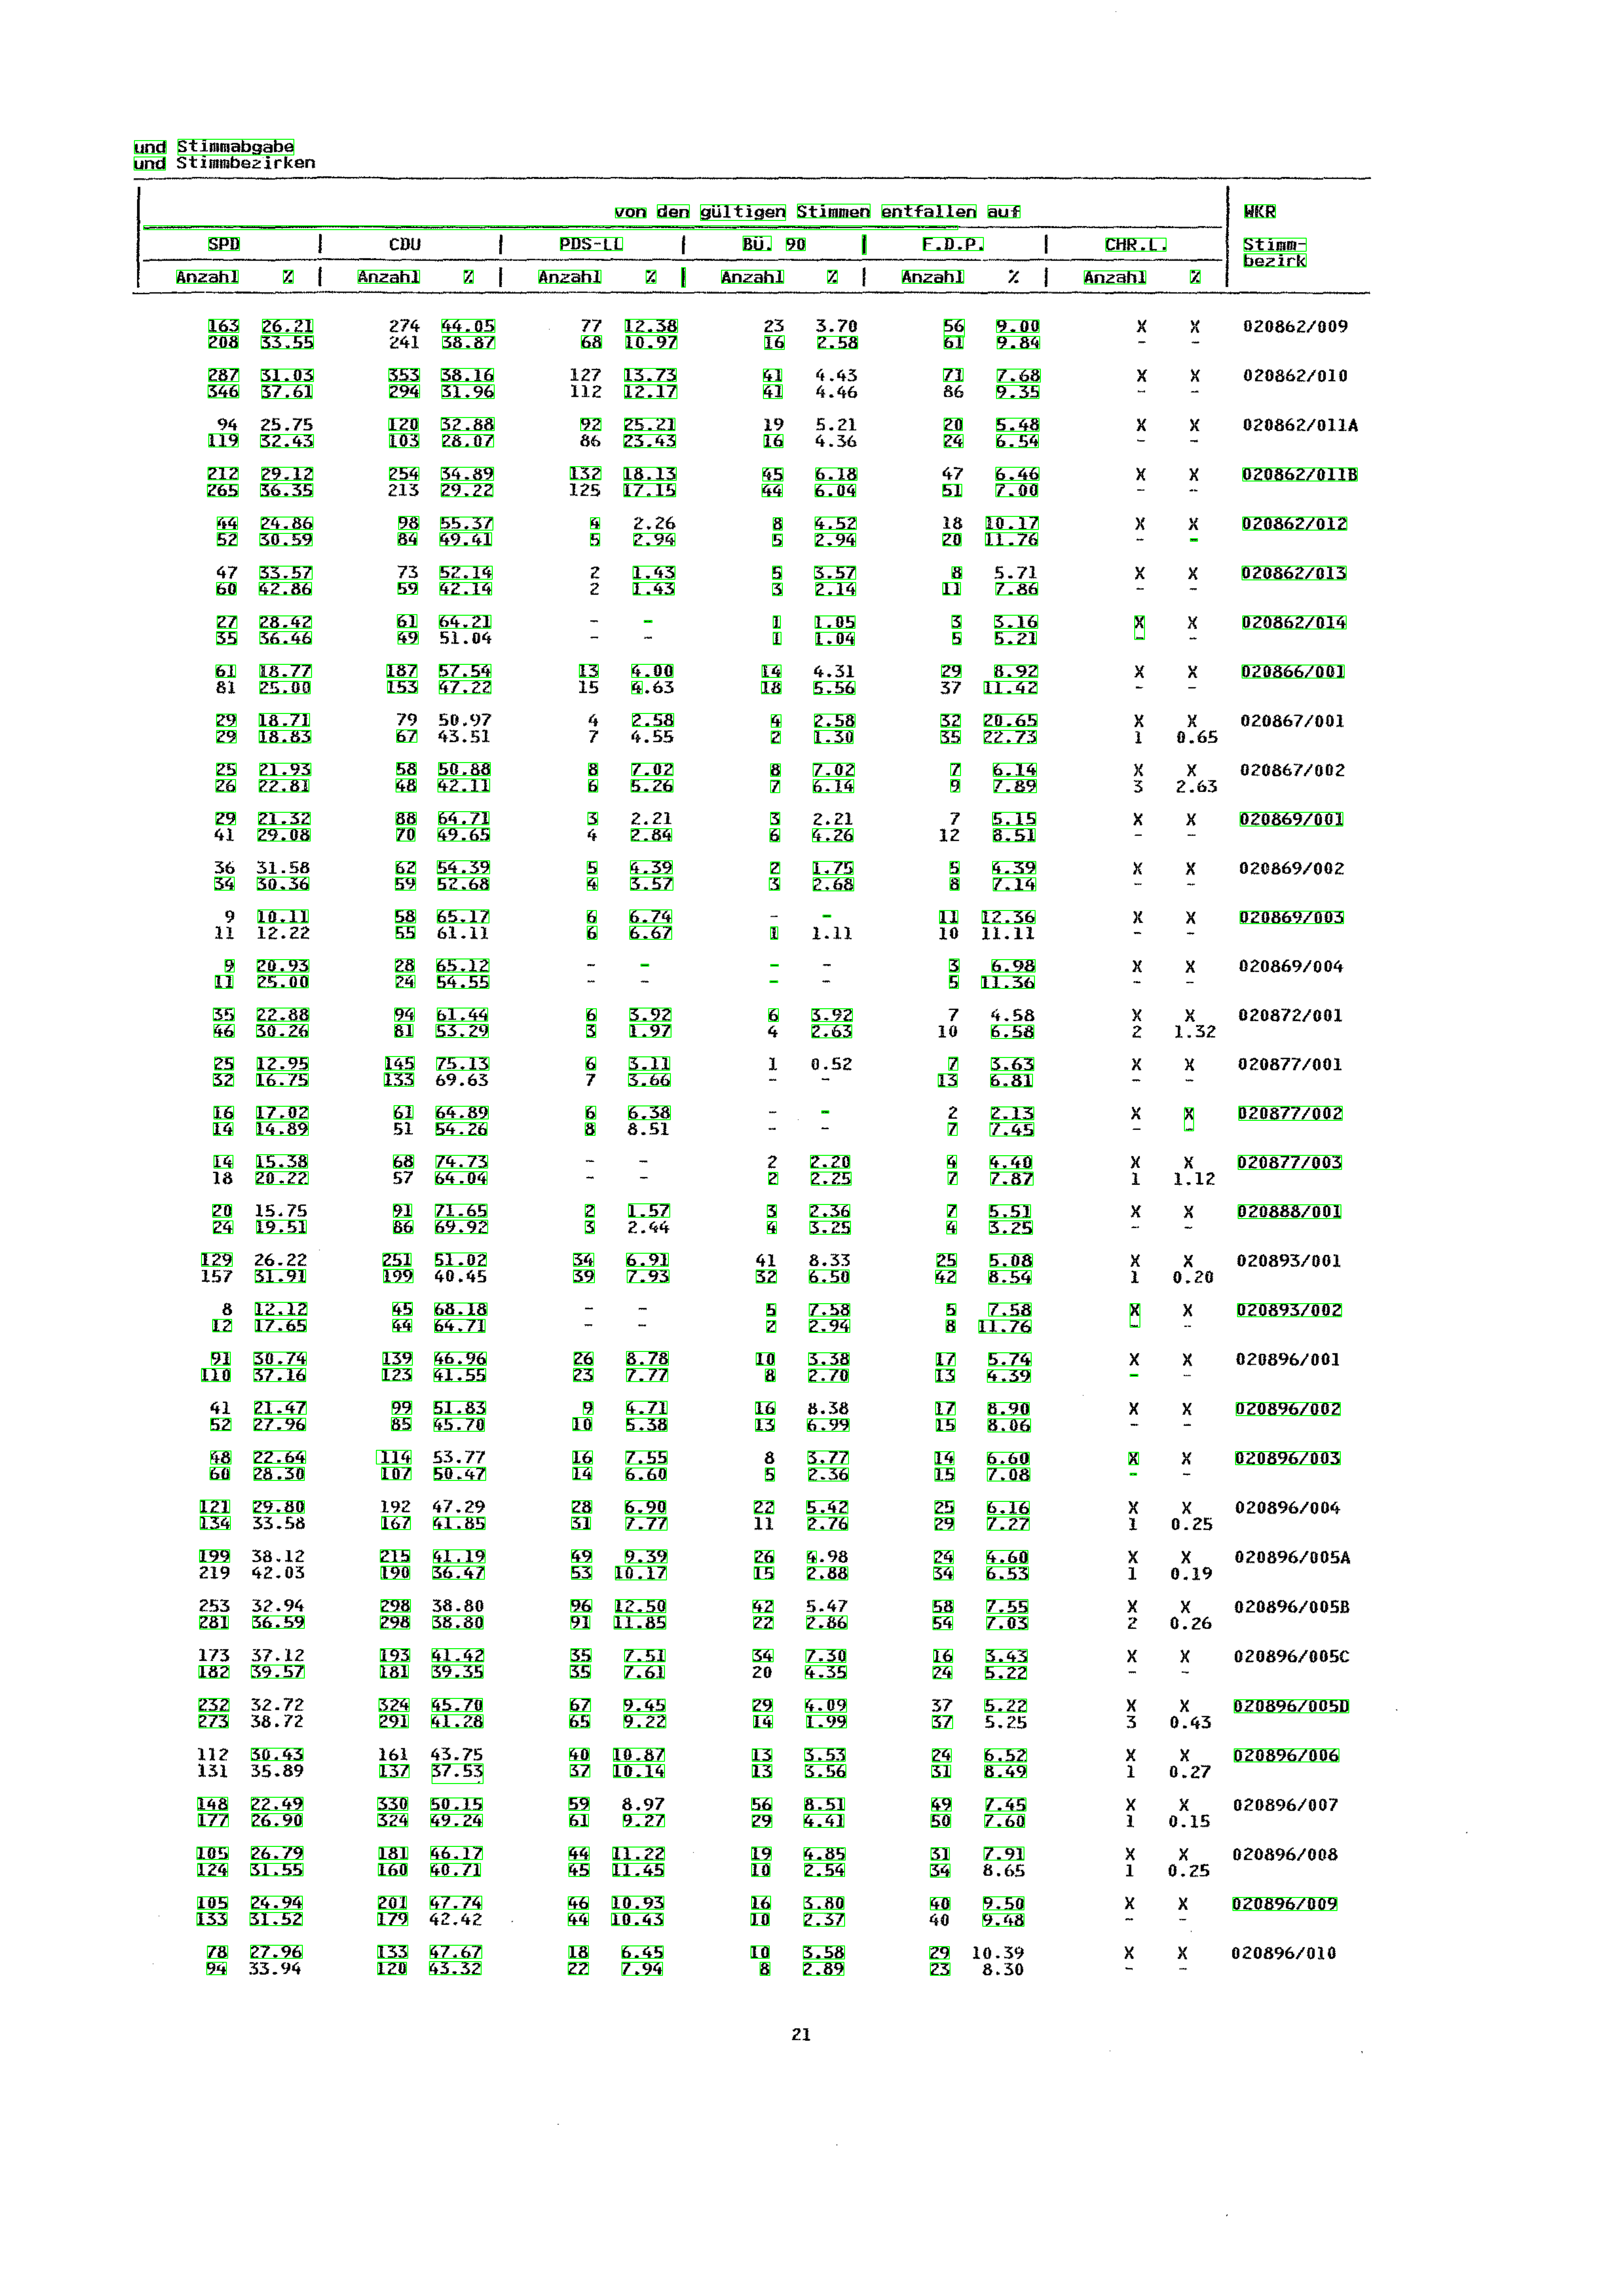

-1

In [ ]:
n_boxes = len(d['text'])
for i in range(n_boxes):
    if float(d['conf'][i]) > 60:
        (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
        img_rect = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

cv2_imshow(img_rect)
cv2.waitKey(0)

With almost no pre-processing we're already doing quite well. 
Two immediate fixes for improvement come to mind:
1. experiment with the **if float(d['conf'][i]) > 30:** condition (it essentially controls how strict we are on filtering by ocr identification confidence) 
2. normalize grey scale on the images 

Let's test if we can return the left party header bounding 

In [ ]:
def get_header_bounding(header, ocr):
  n_boxes = len(ocr['text'])
  for i in range(n_boxes):
    if re.match(header, ocr['text'][i]):
      box = [ocr['left'][i], ocr['top'][i], ocr['width'][i], ocr['height'][i]]
      return box
    
	        

In [ ]:
box_dim = get_header_bounding("PDS-LL", d)
box_dim

[1711, 725, 190, 40]

We really only need the bounding box extent along the x-axis 

In [ ]:
def make_bounding(box_dim):
  return [box_dim[0], box_dim[0] + box_dim[2]]

Buffer the bounding 

In [ ]:
bound_linke = make_bounding(box_dim)
buffer_linke = [bound_linke[0] - 250, bound_linke[1] + 250]
buffer_linke

[1461, 2151]

In [ ]:
def get_col(bound, ocr):
  n_boxes = len(ocr['text'])
  results = []
  for i in range(n_boxes):
    if((ocr['left'][i] > bound[0]) and ((ocr['left'][i] + ocr['width'][i]) < bound[1])):
      results.append([ocr['text'][i]])
  return results


  

In [ ]:
get_col(buffer_linke, d)

Test results on inidividual data entries

In [ ]:
bound_linke = make_bounding(box_dim)
bound_linke = [bound_linke[1]- 20, bound_linke[1] + 200]

In [ ]:
img_crop = img[5025:5080,bound_linke[0]:bound_linke[1]]

In [ ]:
img_crop = img[5025:5080, 3800:4300]

In [ ]:
img.shape

(7014, 4960, 3)

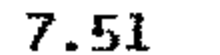

In [ ]:
cv2_imshow(img_crop)

image processing 


In [ ]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)
 
#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 1)
    
#erosion
def erode(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
      angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED) 

In [ ]:
img_new = cv2.bilateralFilter(img_crop,9,75,75)

In [ ]:
n = get_grayscale(img_new)

In [ ]:
n = thresholding(n)

In [ ]:
n = erode(n)

In [ ]:
n = deskew(n)

In [ ]:
n = remove_noise(n)

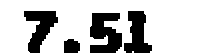

In [ ]:
cv2_imshow(n)

In [ ]:
pytesseract.image_to_string(n) 


'7.51\n\x0c'

a combination of grayscaling, thresholding and eroding seems to perform quite well. 